# Importing relevant modules

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import sklearn.metrics as metrics
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch import arch_model

# Loading dataset

In [25]:
df = pd.read_csv('saveecobot_4230.csv')
df = df.drop(['value_text'], axis=1)
df.head()

,device_id,phenomenon,value,logged_at
0,4230,aqi,65.0,2020-08-11 23:00:00
1,4230,pm25,18.6,2020-08-11 23:00:00
2,4230,temperature,19.0,2020-08-11 23:00:00
3,4230,humidity,88.0,2020-08-11 23:00:00
4,4230,pressure_pa,101500.0,2020-08-11 23:00:00


# Exploration Data Analysis

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124610 entries, 0 to 124609
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   device_id   124610 non-null  int64  
 1   phenomenon  124610 non-null  object 
 2   value       124610 non-null  float64
 3   logged_at   124610 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 3.8+ MB


In [27]:
df.describe()

,device_id,value
count,124610.0,124610.000000
mean,4230.0,20351.991925
std,0.0,40626.486865
min,4230.0,-21.000000
25%,4230.0,13.000000
50%,4230.0,47.000000
75%,4230.0,93.000000
max,4230.0,104800.000000


## Cheking for missing values

In [28]:
df.isnull().sum()

device_id     0
phenomenon    0
value         0
logged_at     0
dtype: int64

In [29]:
print(f'Percentage of "0" entries: {round((df["value"] == 0).sum()/len(df) * 100, 3)} %')

Percentage of "0" entries: 1.924 %


Since the amount of such values are insignificant it's save to delete them.

In [30]:
df = df[df['value'] != 0]

## Transform dates

In [31]:
df['logged_at'] = pd.to_datetime(df['logged_at'])
df

,device_id,phenomenon,value,logged_at
0,4230,aqi,65.0,2020-08-11 23:00:00
1,4230,pm25,18.6,2020-08-11 23:00:00
2,4230,temperature,19.0,2020-08-11 23:00:00
3,4230,humidity,88.0,2020-08-11 23:00:00
4,4230,pressure_pa,101500.0,2020-08-11 23:00:00
...,...,...,...,...
124605,4230,aqi,12.0,2023-09-05 17:00:00
124606,4230,pm25,3.0,2023-09-05 17:00:00
124607,4230,temperature,24.0,2023-09-05 17:00:00
124608,4230,humidity,43.0,2023-09-05 17:00:00


## Transform pressure values

Since the values of pressure_pa are usually higher than 1000, values for this column should be normalized.

In [32]:
df.loc[df['phenomenon'] == 'pressure_pa', 'value'] /= 1000

In [33]:
df['phenomenon'] = df['phenomenon'].replace({'pressure_pa': 'pressure_kpa'})

Too analize futher, data needs to be group by phenomenon and time.

In [34]:
df['logged_at'] = pd.to_datetime(df['logged_at'])
df['hour'] = df['logged_at'].dt.hour
df['month'] = df['logged_at'].dt.month

In [35]:
phenomenons = list(df['phenomenon'].unique())
colors = ['lightcoral', 'palegreen', 'lightblue', 'plum', 'lightpink']

In [36]:
num_categories = len(phenomenons)
num_cols = 2
num_rows = (num_categories + num_cols - 1) // num_cols
confidence_interval = 0.95

### Relationship between phenomenons and months

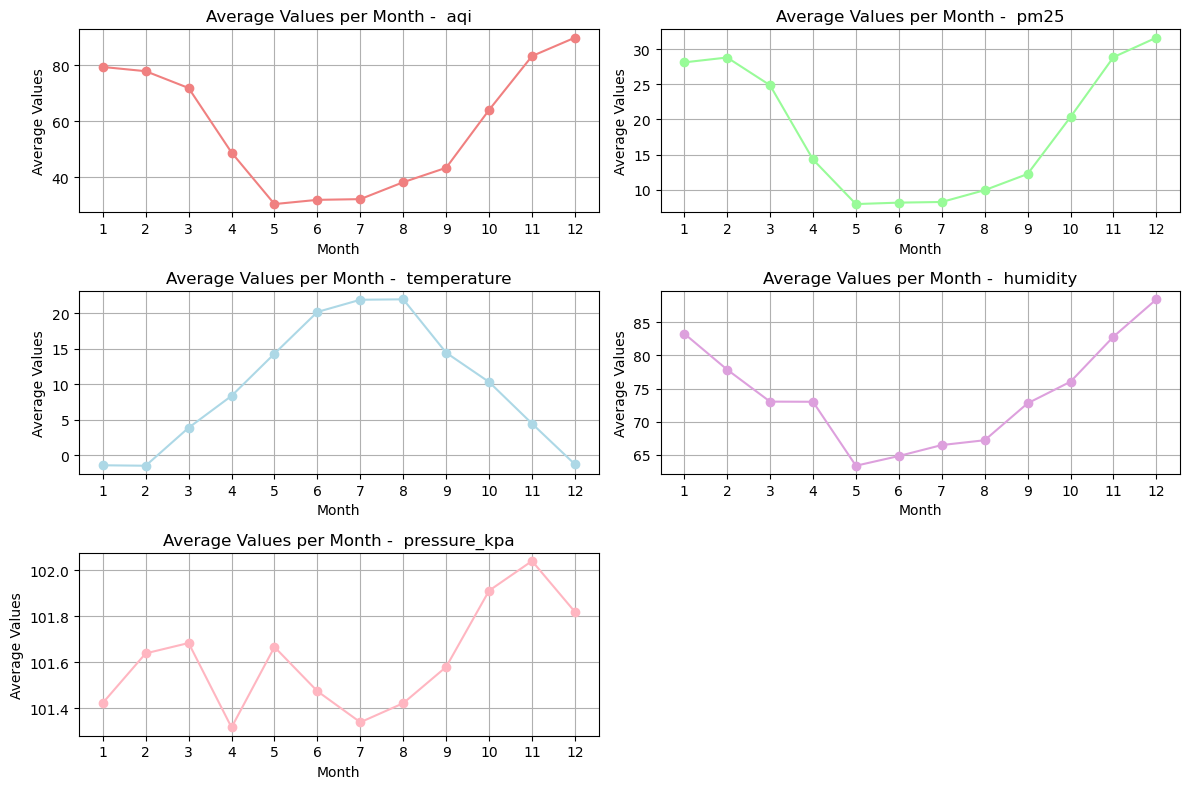

In [37]:

average_values = df.groupby(['phenomenon', 'month'])['value'].mean().reset_index()
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

for i, phenomenon_category in enumerate(phenomenons):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]
    subset_df = average_values[average_values['phenomenon'] == phenomenon_category]
    ax.plot(subset_df['month'], subset_df['value'], marker='o', color=colors[i % len(colors)])
    ax.set_xlabel('Month')
    ax.set_ylabel('Average Values')
    ax.set_title(f'Average Values per Month -  {phenomenon_category}')
    ax.grid(True)
    ax.set_xticks(range(1, 13))

for i in range(num_categories, num_cols * num_rows):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

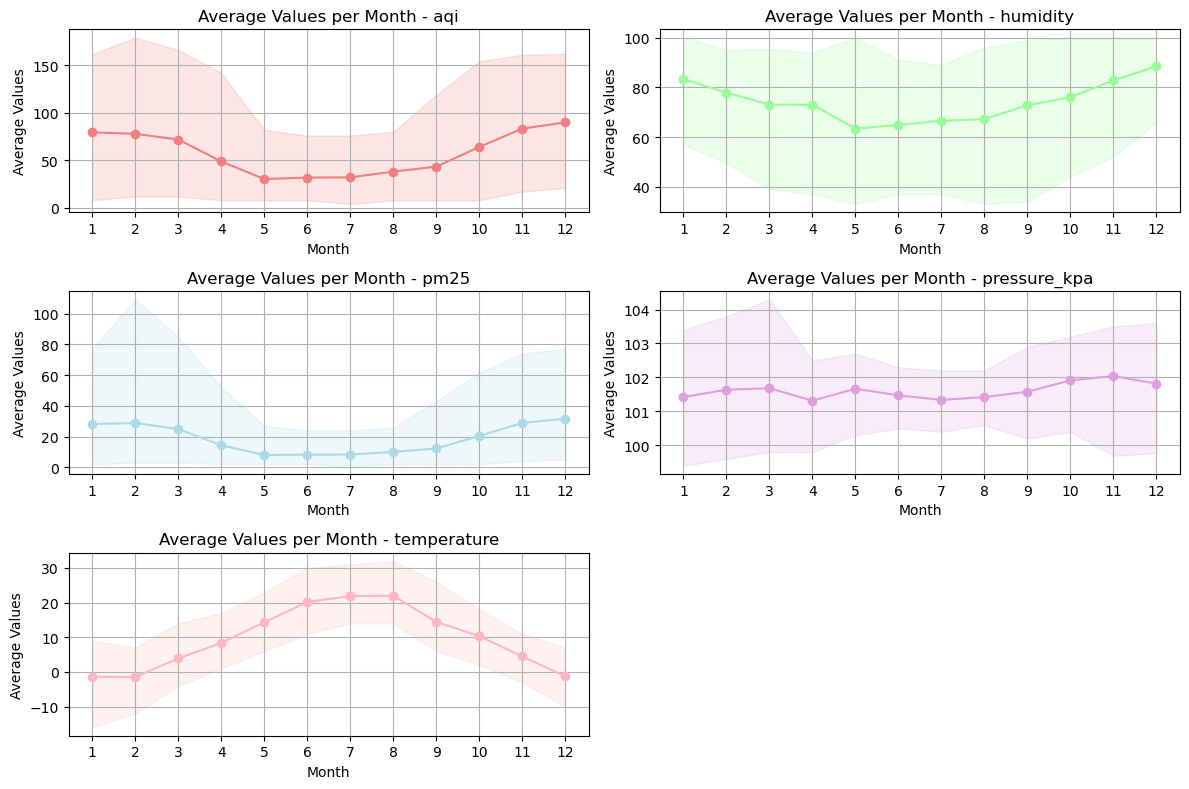

In [38]:
average_values = df.groupby(['phenomenon', 'month'])['value'].agg([np.mean, lambda x: np.percentile(x, q=((1-confidence_interval)*100)/2), lambda x: np.percentile(x, q=100-((1-confidence_interval)*100)/2)]).reset_index()
average_values.columns = ['phenomenon', 'month', 'mean', 'lower_ci', 'upper_ci']


fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

for i, phenomenon_category in enumerate(average_values['phenomenon'].unique()):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]
    
    subset_df = average_values[average_values['phenomenon'] == phenomenon_category]

    ax.plot(subset_df['month'], subset_df['mean'], marker='o', color=colors[i])
    ax.fill_between(subset_df['month'], subset_df['lower_ci'], subset_df['upper_ci'], color=colors[i], alpha=0.2)
    
    ax.set_xlabel('Month')
    ax.set_ylabel('Average Values')
    ax.set_title(f'Average Values per Month - {phenomenon_category}')
    ax.grid(True)
    ax.set_xticks(range(1, 13))

for i in range(num_categories, num_cols * num_rows):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

It is easy to see that:

1. Aqi is much lower during hot seasons (e. g. it is lowest in may, june, july).
2. Pm25 is much lower during hot seasons (e. g. it is lowest in may, june, july).
3. Aqi might be inversly propotional to temperature.
4. Humidity is much lower during hot seasons (e. g. it is lowest in may, june, july).
5. There are many outliers (except for temperature).
6. **Data might be seasonal**

### Relationship between phenomenons and hours

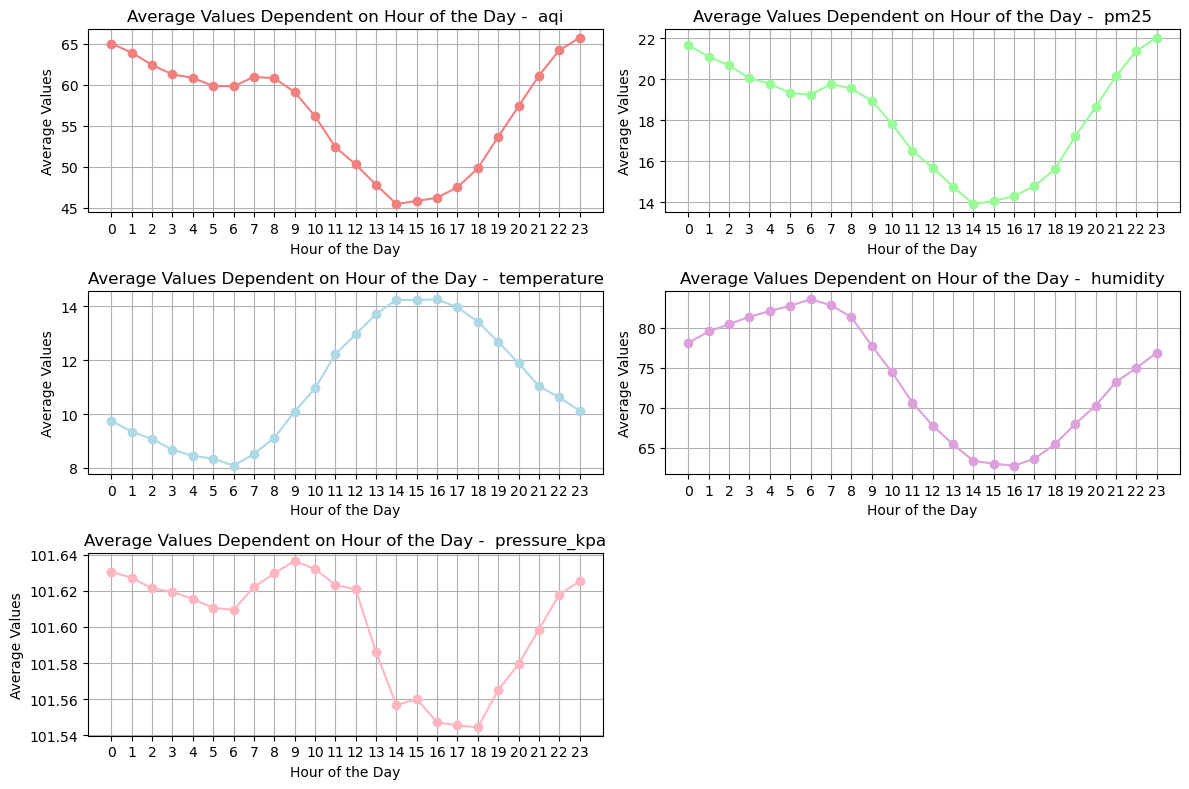

In [39]:
average_values = df.groupby(['phenomenon', 'hour'])['value'].mean().reset_index()
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

for i, phenomenon_category in enumerate(phenomenons):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]

    subset_df = average_values[average_values['phenomenon'] == phenomenon_category]
    ax.plot(subset_df['hour'], subset_df['value'], marker='o', color=colors[i % len(colors)])
    ax.set_xlabel('Hour of the Day')
    ax.set_ylabel('Average Values')
    ax.set_title(f'Average Values Dependent on Hour of the Day -  {phenomenon_category}')
    ax.grid(True)
    ax.set_xticks(range(24))

for i in range(num_categories, num_cols * num_rows):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

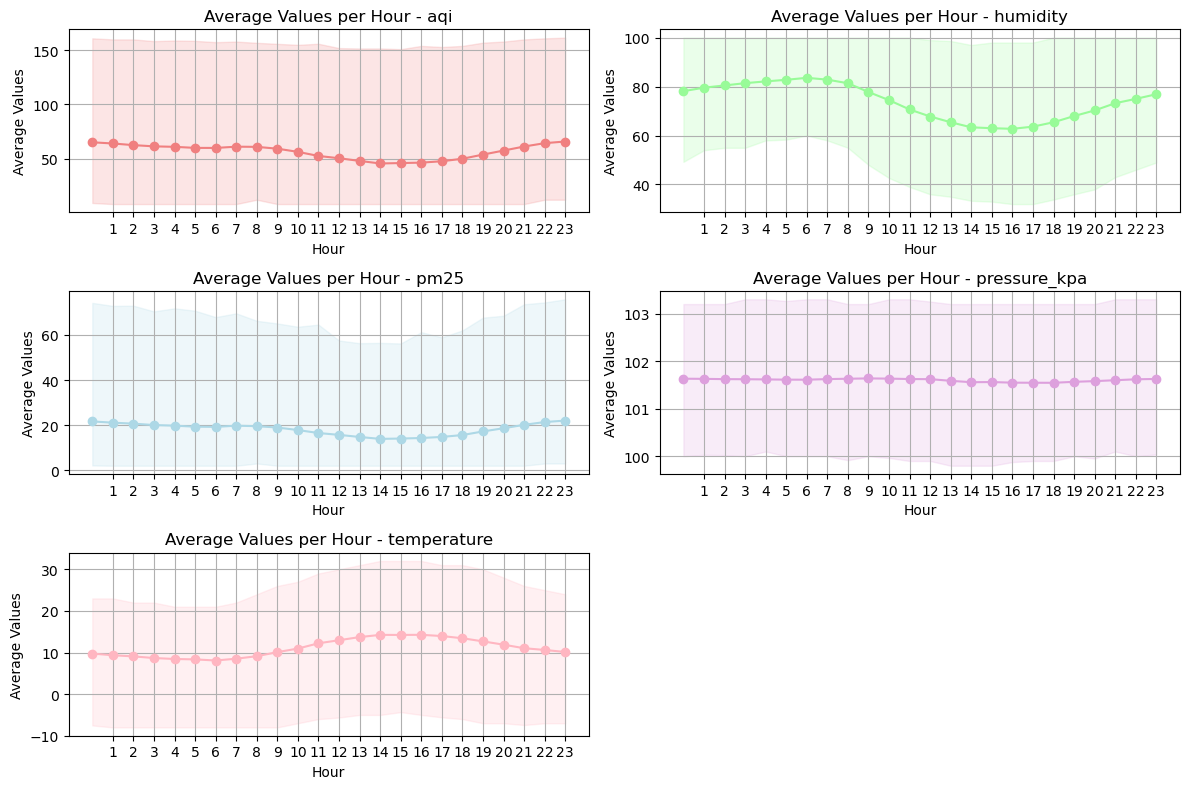

In [40]:
average_values = df.groupby(['phenomenon', 'hour'])['value'].agg([np.mean, lambda x: np.percentile(x, q=((1-confidence_interval)*100)/2), lambda x: np.percentile(x, q=100-((1-confidence_interval)*100)/2)]).reset_index()
average_values.columns = ['phenomenon', 'hour', 'mean', 'lower_ci', 'upper_ci']


fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

for i, phenomenon_category in enumerate(average_values['phenomenon'].unique()):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]
    
    subset_df = average_values[average_values['phenomenon'] == phenomenon_category]

    ax.plot(subset_df['hour'], subset_df['mean'], marker='o', color=colors[i])
    ax.fill_between(subset_df['hour'], subset_df['lower_ci'], subset_df['upper_ci'], color=colors[i], alpha=0.2)
    
    ax.set_xlabel('Hour')
    ax.set_ylabel('Average Values')
    ax.set_title(f'Average Values per Hour - {phenomenon_category}')
    ax.grid(True)
    ax.set_xticks(range(1, 24))

for i in range(num_categories, num_cols * num_rows):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

It is easy to see that:

1. Aqi is much lower at noon.
2. Pm25 is much lower at noon.
3. Aqi might be inversly propotional to temperature.
4. Humidity is much lower at noon.
5. There are **many many** outliers (except for temperature).
6. **It's not clear if data depends on hour of the day**

# Regression analysis

## Finding correlation

In [41]:
entry_counts = df['phenomenon'].value_counts()
entry_counts

humidity        24922
pressure_kpa    24922
pm25            24907
aqi             24906
temperature     22556
Name: phenomenon, dtype: int64

For making correlation matrix values for each phenomenon category needs to be extracted.

In [42]:
grouped_values = df.groupby('phenomenon')['value'].apply(list)
phenomenon_values = {}

for i in range(len(grouped_values)):
    phenomenon_values[phenomenons[i]] = grouped_values[i]


for i in phenomenon_values:
    if len(phenomenon_values[i]) > min(number_of_entries_list):
        phenomenon_values[i] = phenomenon_values[i][:min(number_of_entries_list)]


NameError: name 'number_of_entries_list' is not defined

In [ ]:
phenomenon_values = pd.DataFrame(phenomenon_values)

In [ ]:
phenomenon_values

,aqi,pm25,temperature,humidity,pressure_kpa
0,65.0,88.0,18.6,101.5,19.0
1,66.0,88.0,19.1,101.5,19.0
2,69.0,88.0,20.5,101.5,19.0
3,54.0,72.0,13.4,101.5,18.0
4,39.0,77.0,9.5,101.5,18.0
...,...,...,...,...,...
22551,17.0,44.0,6.0,101.7,25.0
22552,12.0,43.0,4.0,101.7,24.0
22553,12.0,53.0,3.0,101.7,25.0
22554,12.0,56.0,3.0,101.8,24.0


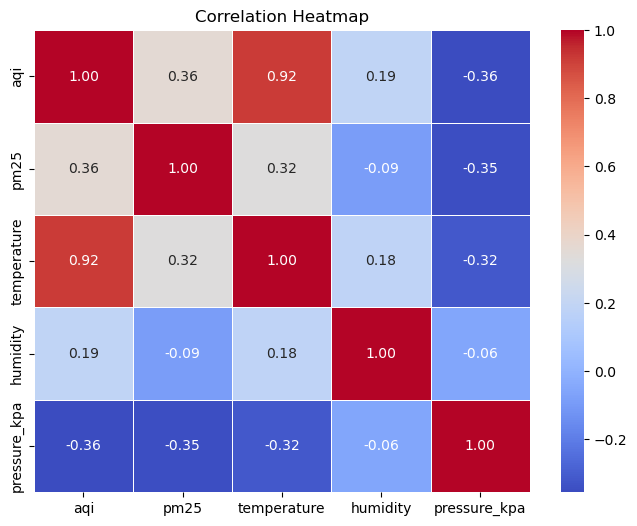

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(phenomenon_values.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

Clearly, there is correlation between aqi and temperature (which makes sense) and there might be correlation between aqi and pm25.

## Making timeseries

In [ ]:
aqi_df = df[df['phenomenon'] == 'aqi']
pm25_df = df[df['phenomenon'] == 'pm25']
aqi_df = aqi_df.sort_values('hour')
pm25_df = pm25_df.sort_values('hour')

In [ ]:
aqi_df

,device_id,phenomenon,value,logged_at,hour,month
10760,4230,aqi,160.0,2020-11-14 00:00:00,0,11
63720,4230,aqi,72.0,2022-03-08 00:00:00,0,3
45775,4230,aqi,45.0,2021-09-29 00:00:00,0,9
93390,4230,aqi,61.0,2022-12-04 00:00:00,0,12
63835,4230,aqi,21.0,2022-03-09 00:00:00,0,3
...,...,...,...,...,...,...
60190,4230,aqi,68.0,2022-02-05 23:00:00,23,2
35935,4230,aqi,49.0,2021-06-29 23:00:00,23,6
60080,4230,aqi,233.0,2022-02-04 23:00:00,23,2
36405,4230,aqi,29.0,2021-07-03 23:00:00,23,7


In [ ]:
ts = aqi_df[['logged_at', 'value']].set_index('logged_at')

In [ ]:
hourly_data = ts['value'].resample('H').mean()
hourly_data = hourly_data.interpolate(method='linear')

In [ ]:
hourly_data

logged_at
2020-08-11 23:00:00    65.0
2020-08-12 00:00:00    66.0
2020-08-12 01:00:00    69.0
2020-08-12 02:00:00    54.0
2020-08-12 03:00:00    39.0
                       ... 
2023-09-05 13:00:00     8.0
2023-09-05 14:00:00     8.0
2023-09-05 15:00:00    12.0
2023-09-05 16:00:00    12.0
2023-09-05 17:00:00    12.0
Freq: H, Name: value, Length: 26875, dtype: float64

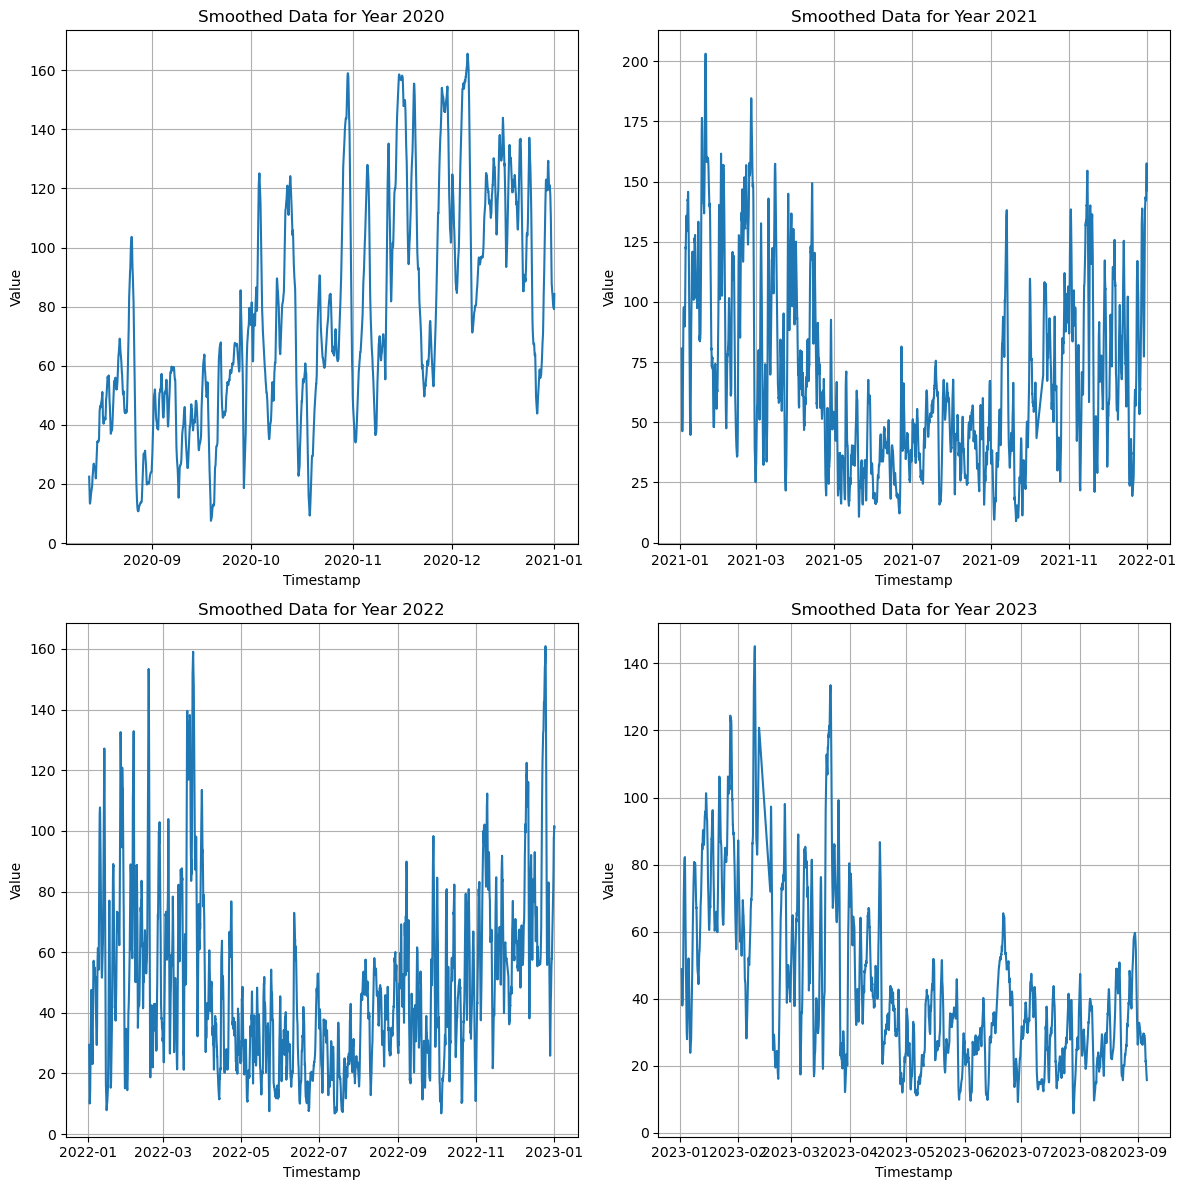

In [ ]:

window_size = 24 

years = [2020, 2021, 2022, 2023]
num_years = len(years)
num_rows = (num_years + 1) // 2 
fig, axs = plt.subplots(num_rows, 2, figsize=(12, 6 * num_rows))

for i, year in enumerate(years):
    row = i // 2
    col = i % 2
    
    year_data = hourly_data[str(year)]
    
    smoothed_data = year_data.rolling(window=window_size).mean()
    
    axs[row, col].plot(smoothed_data.index, smoothed_data.values)
    axs[row, col].set_title(f'Smoothed Data for Year {year}')
    axs[row, col].set_xlabel('Timestamp')
    axs[row, col].set_ylabel('Value')
    axs[row, col].grid(True)

plt.tight_layout()
plt.show()


## Decomposing timeseries

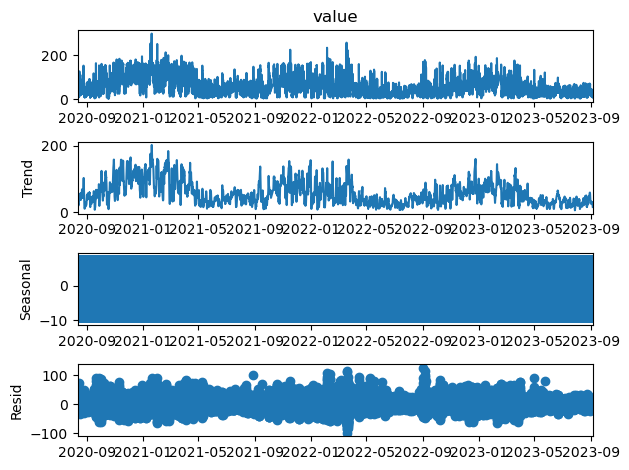

In [ ]:
from random import randrange
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
series = hourly_data
result = seasonal_decompose(series, model='additive')
result.plot()
pyplot.show()

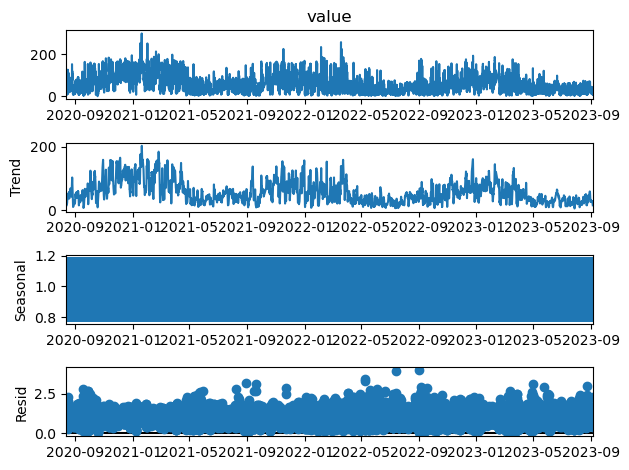

In [ ]:
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
series = hourly_data
result = seasonal_decompose(series, model='multiplicative')
result.plot()
pyplot.show()

## Test/train split

In [ ]:
X_train = aqi_df.loc[(aqi_df['logged_at'] >= '2021-01-01') & (aqi_df['logged_at'] <= '2022-12-31'), 
                             ['device_id', 'phenomenon', 'value', 'logged_at', 'hour', 'month']]
y_train = pm25_df.loc[(pm25_df['logged_at'] >= '2021-01-01') & (pm25_df['logged_at'] <= '2022-12-31'), 
                             ['device_id', 'phenomenon', 'value', 'logged_at', 'hour', 'month']]
X_test = pm25_df[pm25_df['logged_at'].dt.year == 2023]
y_test = pm25_df[pm25_df['logged_at'].dt.year == 2023]

## Choosing parameters 

/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


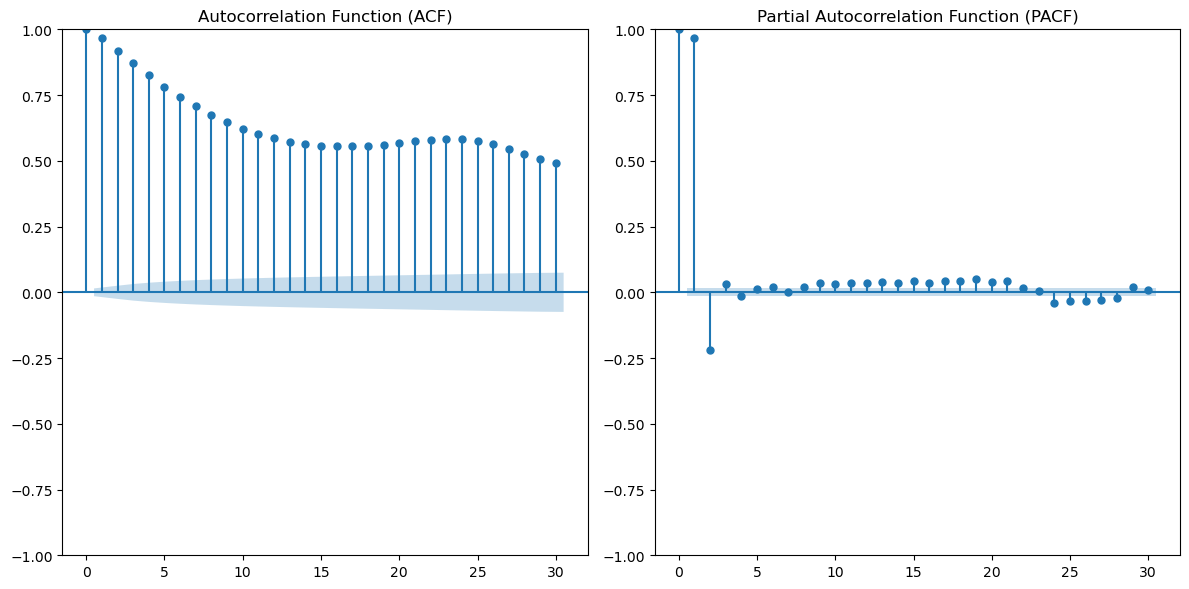

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
plot_acf(train_data, lags=30, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)')
plot_pacf(train_data, lags=30, ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()


## ARIMA

In [ ]:
p, d, q = 3, 0, 2
model = ARIMA(train_data, order=(p, d, q))
model_fit = model.fit()

/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [ ]:
forecast_steps = len(test_data)
forecast_results = model_fit.predict(start=len(train_data), end=len(train_data)+forecast_steps-1, typ='levels', dynamic=True)
forecast_values = forecast_results
confidence_intervals = model_fit.get_forecast(steps=forecast_steps).conf_int()
forecast_index = pd.date_range(start='2023-01-01 00:00:00', periods=forecast_steps, freq='H')
forecast_df = pd.DataFrame({'forecasted_value': forecast_values, 
                            'lower_confidence': confidence_intervals.iloc[:, 0],
                            'upper_confidence': confidence_intervals.iloc[:, 1]}, 
                           index=forecast_index)

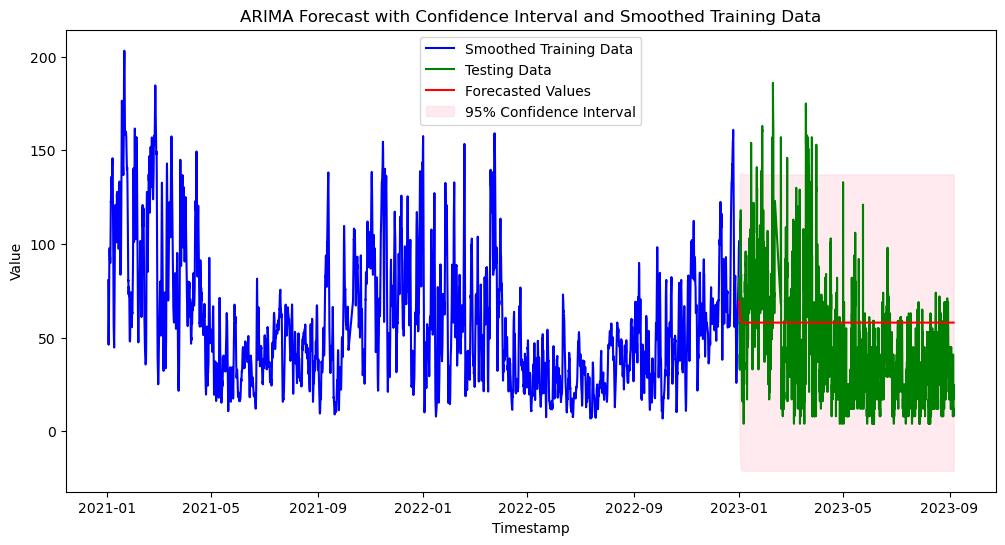

In [ ]:
window_size = 24
smoothed_train_data = train_data.rolling(window=window_size).mean()
plt.figure(figsize=(12, 6))
plt.plot(smoothed_train_data, label='Smoothed Training Data', color='blue')
plt.plot(test_data, label='Testing Data', color='green')
plt.plot(forecast_df.index, forecast_df['forecasted_value'], color='red', label='Forecasted Values')
plt.fill_between(forecast_df.index, forecast_df['lower_confidence'], forecast_df['upper_confidence'], color='pink', alpha=0.3, label='95% Confidence Interval')
plt.title('ARIMA Forecast with Confidence Interval and Smoothed Training Data')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()


/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


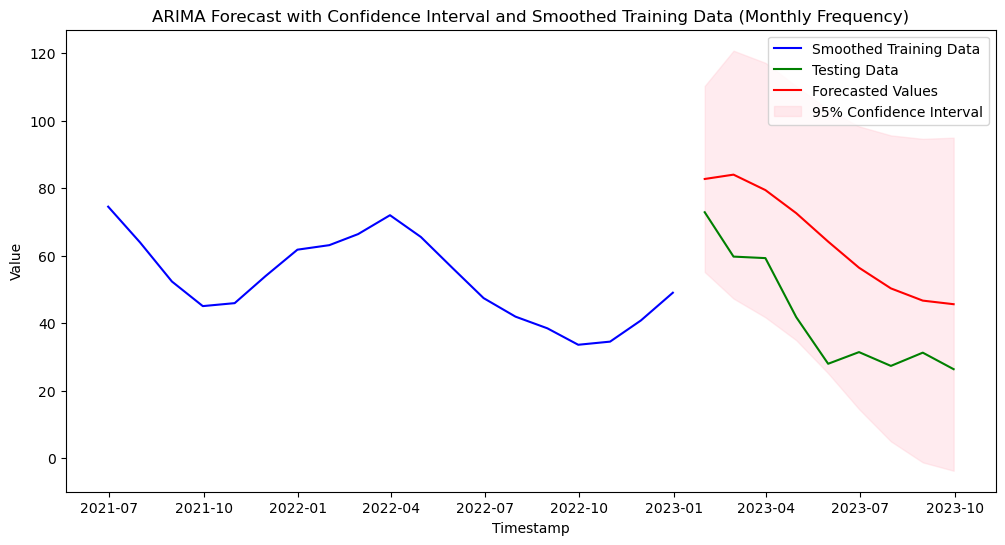

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Assuming you have monthly data with a datetime index
ts = aqi_df[['logged_at', 'value']].set_index('logged_at')
monthly_data = ts['value'].resample('M').mean()
monthly_data = monthly_data.interpolate(method='linear')

# Define the training and testing date ranges
train_start_date = '2021-01-01'
train_end_date = '2022-12-31'
test_start_date = '2023-01-01'
test_end_date = '2023-12-31'

# Filter the data for training and testing
train_data = monthly_data[train_start_date:train_end_date]
test_data = monthly_data[test_start_date:test_end_date]

# Define the ARIMA order (p, d, q)
p, d, q = 3, 0, 2

# Fit the ARIMA model to the training data
model = ARIMA(train_data, order=(p, d, q))
model_fit = model.fit()

# Forecast future values (2023)
forecast_steps = len(test_data)
forecast_results = model_fit.predict(start=len(train_data), end=len(train_data) + forecast_steps - 1, typ='levels', dynamic=True)
forecast_values = forecast_results
confidence_intervals = model_fit.get_forecast(steps=forecast_steps).conf_int()
forecast_index = pd.date_range(start=test_start_date, periods=forecast_steps, freq='M')

# Create a DataFrame for the forecasted values with a datetime index
forecast_df = pd.DataFrame({'forecasted_value': forecast_values,
                            'lower_confidence': confidence_intervals.iloc[:, 0],
                            'upper_confidence': confidence_intervals.iloc[:, 1]},
                           index=forecast_index)

# Apply smoothing to the time series data
window_size = 6  # Adjust the window size for monthly data
smoothed_train_data = train_data.rolling(window=window_size).mean()

# Plot the smoothed data, testing data, forecasted values, and confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(smoothed_train_data, label='Smoothed Training Data', color='blue')
plt.plot(test_data, label='Testing Data', color='green')
plt.plot(forecast_df.index, forecast_df['forecasted_value'], color='red', label='Forecasted Values')
plt.fill_between(forecast_df.index, forecast_df['lower_confidence'], forecast_df['upper_confidence'], color='pink', alpha=0.3, label='95% Confidence Interval')
plt.title('ARIMA Forecast with Confidence Interval and Smoothed Training Data (Monthly Frequency)')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()


In [ ]:
train_data

NameError: name 'train_data' is not defined

In [ ]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                17520
Model:                 ARIMA(3, 0, 2)   Log Likelihood              -65550.362
Date:                Mon, 11 Sep 2023   AIC                         131114.724
Time:                        18:39:34   BIC                         131169.122
Sample:                    01-01-2021   HQIC                        131132.636
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         58.0165      2.292     25.308      0.000      53.523      62.510
ar.L1          0.3734      0.655      0.570      0.568      -0.910       1.656
ar.L2          0.6112      0.663      0.923      0.3

In [ ]:
mse = mean_squared_error(test_data, forecast_values)
rmse = np.sqrt(mse)

print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 33.35337692573732


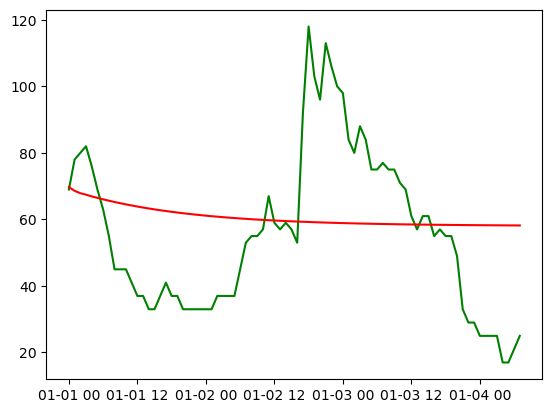

In [ ]:
plt.plot(test_data[:80], label='Testing Data', color='green')
plt.plot(forecast_df.index[:80], forecast_df['forecasted_value'][:80], color='red', label='Forecasted Values')

## LR

In [ ]:
X_train = np.array(X_train['value']).reshape(-1, 1)
y_train = np.array(y_train['value']).reshape(-1, 1)
X_test = np.array(X_test['value']).reshape(-1, 1)
y_test = np.array(y_test['value']).reshape(-1, 1)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
len(y_train)

15928

In [ ]:
regr = LinearRegression().fit(X_train, y_train)
y_pred = regr.predict(X_test)

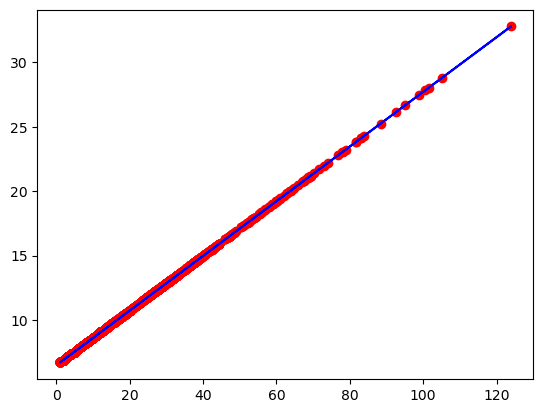

In [ ]:
plt.scatter(X_test.flatten(),y_pred.flatten(), color='red') 
plt.plot(X_test, y_pred,color='blue') 

In [ ]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 9.495814183245788
